# <center>Organizaci&oacute;n de Datos</center>
## <center>Trabajo Práctico 1 : Reservas de Hotel</center>
## <center>Checkpoint 3</center>
### <center>Ensambles: SVM</center>

#### Integrantes grupo 19: Sudanalytics 
* Adrian Leandro Re
* Alan Toulouse
* Luciano Lorenzo
* Nicolas Tonizzo

# Imports y preparacion del dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("../dataset/hotels_train_procesado.csv")
df.columns

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status_date', 'id', 'is_canceled', 'hotel_encoding',
       'tiene_hijos', 'es_extranjero', 'es_portugues', 'es_ingles',
       'es_frances', 'es_espanol', 'es_aleman', 'reserved_room_was_assigned',
       'required_a_car_parking_space', 'solo_desayuna_en_el_hotel',
       'pidio_todas_comidas', 'reservo_online', 'reservo_en_grupo',
       'reservo_sin_reembols

Declaramos el target y los features del dataframe que vamos a utilizar para predecir.

In [3]:
target = "is_canceled"

attrs = [
    "hotel_encoding",
    
    "lead_time",
    #"reservo_el_mismo_dia",
    "adr",

    #"stays_in_weekend_nights",
    "stays_in_week_nights",

    "tiene_hijos",
    "adults",
    # "children",
    # "babies",

    # Fechas
    "arrival_date_week_number",
    #"arrival_date_day_of_month",
    "arrival_date_year",

    "es_extranjero",
    #"es_portugues",
    #"es_ingles",
    #"es_frances",
    #"es_espanol",
    #"es_aleman",

    "reserved_room_was_assigned",

    "is_repeated_guest",
    "previous_cancellations", 
    #"previous_bookings_not_canceled",
    #"total_reservas_previas"
    "total_of_special_requests",
    "booking_changes",

    #'meal',
    "solo_desayuna_en_el_hotel",
    "pidio_todas_comidas",

    # 'required_car_parking_spaces',
    "required_a_car_parking_space",

    "reservo_sin_reembolso",
    "reservo_sin_depositar",
    "reservo_online",
    "reservo_en_grupo",
    "reservo_sin_compania",
    "reservo_sin_agente",
    "reservo_sin_paquete",
    
    # "days_in_waiting_list",
    "tuvo_dias_de_espera",
    
    "agent9",
    "agent240",
    "agent1",
    "agent14",
    "agent6",
]

**Dividimos el dataset en entrenamiento y validacion**, para poder validar que no estamos overfitteando al dataset de entrenamiento, y que el modelo predice bien a registros no vistos anteriormente. Vamos a utilizar mitad de el dataset para validacion y mitad del dataset para entrenamiento, ya que haciendo varias pruebas, SVC tarda muchisimo tiempo si el dataset es muy grande. De hecho para las pruebas usamos el split de entrenamiento todavia mas chico, para poder tener una idea general de cuales deberian ser los mejores parametros.

In [4]:
X = df[attrs].values
y = df[target].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, shuffle=True)

Vamos a utilizar PCA para reducir las dimensiones en los datos, e intentar reducir los tiempos de entrenamiento, a su vez que reducimos el overfitting. Nos viene bien porque ambos (PCA Y SVM) necesitan que los datos esten centrados, en este caso utilizamos el standard scaler. Graficamos la varianza explicada en funcion del numero de componentes para tener una idea del numero de componentes a utilizar:

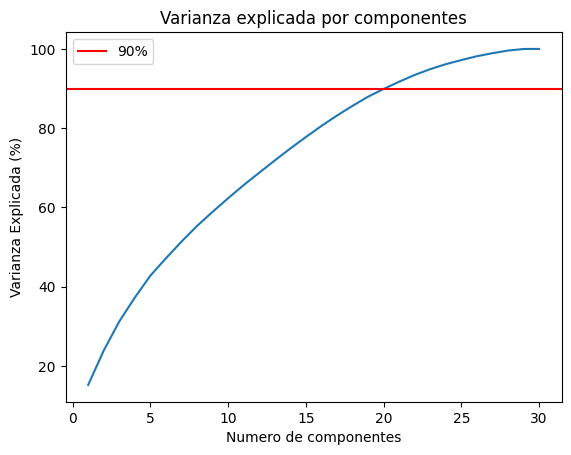

In [29]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)

pca = PCA(n_components = None)
pca.fit(X_train_scaled)

#Cantidad de Componentes
componentes = len(pca.explained_variance_ratio_) 

#Grafico la Varianza Explicada 
plt.plot(range(1,componentes+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.axhline(90, c= 'red', label='90%')
plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada (%)")
plt.title("Varianza explicada por componentes")
plt.legend()

Observando el plot concluimos que un buen numero de componentes, que por lo menos el 0.9 de varianza explicada, tiene que mayor que 21.

# SVM con rbf

rbf es un kernel con el que podemos entrenar nuestro modelo. Utiliza una funcion de verosimilitud para formar las nuevas 'dimensiones'. Cada nueva dimension es un valor que mide la similitud con otro, el cual elegimos como referencia.

Es el kernel default en SVC de sklearn.

Creamos el pipeline, el cual comienza por estandarizar el dataset, ya que ambos PCA y SVM lo necesitan.

In [13]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("svm", SVC(kernel='rbf')),
])

Luego de un par de pruebas individuales con el pipe, concluimos que un buen rango para poner los valores de los hiperparametros a ser optimizados por cross validation es el siguiente:

In [14]:
params_grid = {
    "pca__n_components": list(range(21, 30)),
    "svm__C": list(range(10, 30)), 
    "svm__gamma": np.linspace(0.001, 0.1, 30),
}

`C`: Parametro de regularizacion. El valor de C es inversamente proporcional a la regularizacion (mas alto C, menos regularizado). Nos sirve para evitar que el modelo cause overfitting.

`gamma`: Es un parametro que determina la influencia de un solo sample en la regla de decision que toma en svm.

Utilizamos cross validation randomizado para encontrar los mejores hiperparametros:

In [16]:
kfoldcv = StratifiedKFold(n_splits=4)

model = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params_grid,
    scoring=make_scorer(f1_score),
    cv=kfoldcv,
    n_iter=6,
    n_jobs=-1,
)

In [17]:
model.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()), ('svm', SVC())]),
                   n_iter=6, n_jobs=-1,
                   param_distributions={'pca__n_components': [21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29],
                                        'svm__C': [10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29],
                                        'svm__gamma': array([0.001     , 0.00441379, 0.00782759, 0.01124138, 0.01465517,
       0.01806897, 0.02148276, 0.02489655, 0.02831034, 0.03172414,
       0.03513793, 0.03855172, 0.04196552, 0.04537931, 0.0487931 ,
       0.0522069 , 0.05562069, 0.05903448, 0.06244828, 0.06586207,
       0.06927586, 0.07268966, 0.07610345, 0.07951724, 0.08293103,
       0.08634483, 0.08975862, 0.09317241, 0.09658621, 0.1       ])},
                   scoring=make_scorer(f1_score))

Despues de un largo rato esperando, su mejor resultado fue:

In [18]:
model.best_score_

0.8519857969691145

Mejores parametros

In [19]:
model.best_params_

{'svm__gamma': 0.048793103448275865, 'svm__C': 16, 'pca__n_components': 23}

Score en validacion y training:

In [20]:
model.score(X_val, y_val)

0.8602529214022732

In [21]:
model.score(X_train, y_train)

0.887559354226021

Podemos visualizar las estadisticas completas del cross validation:

In [22]:
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__gamma,param_svm__C,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,101.673446,6.678887,5.299777,0.729663,0.086345,11,26,"{'svm__gamma': 0.0863448275862069, 'svm__C': 1...",0.850038,0.854391,0.847810,0.855485,0.851931,0.003133,2
1,55.118869,4.277716,5.013591,0.281117,0.048793,16,23,"{'svm__gamma': 0.048793103448275865, 'svm__C':...",0.851069,0.851781,0.852617,0.852476,0.851986,0.000616,1
2,63.691526,5.957073,5.333192,0.474748,0.065862,20,21,"{'svm__gamma': 0.06586206896551725, 'svm__C': ...",0.847868,0.851236,0.849734,0.854800,0.850909,0.002543,5
3,35.255084,0.451165,5.851206,1.303822,0.031724,10,23,"{'svm__gamma': 0.031724137931034485, 'svm__C':...",0.851516,0.851889,0.851269,0.851204,0.851470,0.000269,4
4,36.728707,1.758201,6.603431,0.404241,0.004414,13,27,"{'svm__gamma': 0.004413793103448276, 'svm__C':...",0.841288,0.839843,0.838775,0.841797,0.840426,0.001193,6
5,81.409657,7.237716,5.091568,0.701531,0.076103,17,27,"{'svm__gamma': 0.07610344827586207, 'svm__C': ...",0.851573,0.854032,0.846630,0.854371,0.851652,0.003094,3


Ploteamos las matrices de confusion, ambas para el conjunto de entrenamiento como el de validacion:

precision 0.8752028967411661
recall 0.9002697148728487


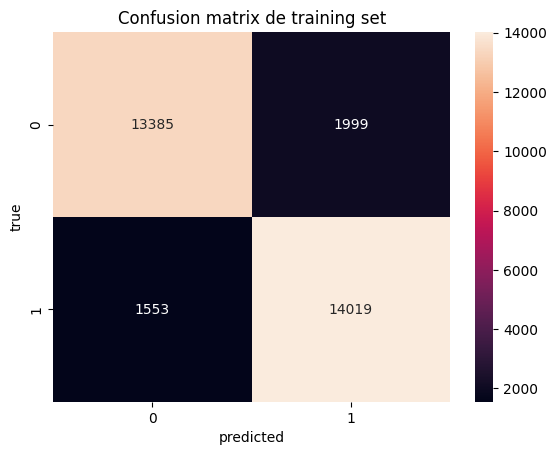

In [23]:
y_pred = model.predict(X_train)
confusion = confusion_matrix(y_train, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de training set")
print("precision", precision_score(y_train, y_pred))
print("recall", recall_score(y_train, y_pred))

precision 0.8467792764401866
recall 0.8741622747088295


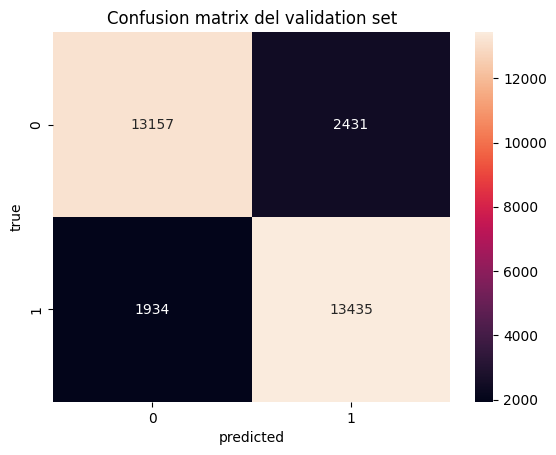

In [24]:
y_pred = model.predict(X_val)
confusion = confusion_matrix(y_val, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix del validation set")
print("precision", precision_score(y_val, y_pred))
print("recall", recall_score(y_val, y_pred))

# SVM polinomico

Ahora vamos a cambiar el kernel del SVM a uno polinomico (para probar algo distinto), es cierto que esto lo podriamos haber hecho todo junto dentro del RandomizedSearchCV, pero queriamos obtener resultados optimizados para ambos kernels especificamente. 

Por lo que volvemos a definir la grilla de parametros y el nuevo pipeline:

In [5]:
params_grid = {
    "svm__C": list(range(10, 30)), 
    "svm__gamma": np.linspace(0.001, 0.1, 30),
    "svm__degree": [3,4,5,6],
}

El nuevo parametro `degree`, determina el grado del polinomio que utiliza la kernel function. 

In [6]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=24)),
    ("svm", SVC(kernel='poly')),
])

In [7]:
kfoldcv = StratifiedKFold(n_splits=4)

model = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params_grid,
    scoring=make_scorer(f1_score),
    cv=kfoldcv,
    n_iter=3,
    n_jobs=3,
)

In [8]:
model.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA(n_components=24)),
                                             ('svm', SVC(kernel='poly'))]),
                   n_iter=3, n_jobs=3,
                   param_distributions={'svm__C': [10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29],
                                        'svm__degree': [3, 4, 5, 6],
                                        'svm__gamma': array([0.001     , 0.00441379, 0.00782759, 0.01124138, 0.01465517,
       0.01806897, 0.02148276, 0.02489655, 0.02831034, 0.03172414,
       0.03513793, 0.03855172, 0.04196552, 0.04537931, 0.0487931 ,
       0.0522069 , 0.05562069, 0.05903448, 0.06244828, 0.06586207,
       0.06927586, 0.07268966, 0.07610345, 0.07951724, 0.08293103,
       0.08634483, 0.08975862, 0.09317241, 0.09658621, 0.1       ])},
                   scoring=make_scorer(f1_score))

In [9]:
model.score(X_val, y_val)

0.8438444230151076

In [10]:
model.best_params_

{'svm__gamma': 0.014655172413793105, 'svm__degree': 3, 'svm__C': 11}

In [11]:
model.best_score_

0.8364173324625639

Observamos que **tiene un peor performance** que el que utiliza el kernel RBF.

# Creacion de submit

In [ ]:
def create_submission(model): 
    df_test = pd.read_csv("../dataset/hotels_test_procesado.csv")
    assert(len(df_test)==26535)

    prediccion = model.predict(df_test[attrs].values)
    assert(len(prediccion)==26535)

    submit = pd.DataFrame(
        {"is_canceled": prediccion},
        index=df_test["id"],
    )
    assert(len(submit)==26535)

    submit.to_csv("../dataset/submit.csv")

In [ ]:
create_submission(model)

# Guardando el modelo con pickle

Guardamos la svm con pickle:

In [ ]:
import pickle

with open('../modelos/svm.pickle', 'wb') as file:
    pickle.dump(model, file)